In [2]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/mssmartypants/rice-type-classification')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gaganpoojari
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mssmartypants/rice-type-classification


100%|██████████| 888k/888k [00:00<00:00, 658MB/s]

KGAT_93fb0fae2fdc5c8514f82f5cb949aec7

In [3]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Tell pytorch that were using a GPU (CUDA in this case)
device = 'cuda' if torch.cuda.is_available else 'cpu'
print(device)

cuda


In [4]:
data_df = pd.read_csv('/content/rice-type-classification/riceClassification.csv')
data_df.head()

,id,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,1,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,4,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,5,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [5]:
data_df.dropna(inplace=True)
data_df.drop(['id'], axis=1, inplace=True) # axis=1 specifies that it is a column not a row
print(data_df.shape)

(18185, 11)


In [6]:
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [7]:
print(data_df['Class'].unique())
print(data_df['Class'].value_counts())

[1 0]
Class
1    9985
0    8200
Name: count, dtype: int64


In [8]:
# NORMALIZATION (since the values are huge, weights are small, hence not computaionally effective)
# here, we'll be dividing every col vlas with max col val
og_df = data_df.copy()

for col in data_df.columns:
  data_df[col] = data_df[col] / data_df[col].abs().max()
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


In [9]:
# PRE-PROCESSING

# TRAIN VALIDATION TEST SPLIT
X = np.array(data_df.iloc[:, :-1])
y = np.array(data_df.iloc[:, -1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5)

print(X_train.shape) # 75%
print(X_test.shape) # 15%
print(X_valid.shape) # 15%

(12729, 10)
(2728, 10)
(2728, 10)


In [10]:
# Creating a pytorch dataset object

class dataset(Dataset):
  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32).to(device)
    self.y = torch.tensor(y, dtype=torch.float32).to(device)

  # helps in training

  # return shape
  def __len__(self):
    return len(self.X)

  # return row / example
  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [11]:
# prepare the 3 datasets
training_data = dataset(X_train, y_train)
validation_data = dataset(X_valid, y_valid)
test_data = dataset(X_test, y_test)

In [12]:
# DATALOADER
train_dataloader = DataLoader(training_data, batch_size=8, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True)

In [13]:
# demonstration of dataloader
for x, y in train_dataloader:
  print(x)
  print('-------------')
  print(y)
  break

tensor([[0.6768, 0.8728, 0.6799, 0.9686, 0.6432, 0.8227, 0.7166, 0.7046, 0.7476,
         0.7283],
        [0.5091, 0.8202, 0.5471, 0.9866, 0.4883, 0.7135, 0.5265, 0.6441, 0.6730,
         0.8507],
        [0.9977, 0.8905, 0.9791, 0.8985, 0.9510, 0.9989, 0.7175, 0.7933, 0.8696,
         0.5160],
        [0.4632, 0.7379, 0.5505, 0.9742, 0.4404, 0.6806, 0.5849, 0.5883, 0.7340,
         0.7605],
        [0.8472, 0.8546, 0.8712, 0.9188, 0.8189, 0.9204, 0.7454, 0.7474, 0.8317,
         0.5565],
        [0.6201, 0.8854, 0.6156, 0.9823, 0.5909, 0.7875, 0.5161, 0.7013, 0.6914,
         0.8159],
        [0.7322, 0.7776, 0.8197, 0.9103, 0.7007, 0.8557, 0.8364, 0.6811, 0.8655,
         0.5382],
        [0.6392, 0.8981, 0.6251, 0.9822, 0.6120, 0.7995, 0.4997, 0.7152, 0.6853,
         0.8151]], device='cuda:0')
-------------
tensor([1., 1., 0., 1., 0., 1., 0., 1.], device='cuda:0')


In [14]:
HIDDEN_NEURONS = 10
# Building the model (inheritence of nn.Model)
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    # Creating layers:
    self.input_layer = nn.Linear(X.shape[1], HIDDEN_NEURONS)
    # arg1 -X.shape[1]: how many neurons the input layer has (input)
    # arg2 - HIDDEN_NEURONS: how many neurons will it output (for the next layer)
    self.linear = nn.Linear(HIDDEN_NEURONS, 1) # hidden layer
    self.sigmoid = nn.Sigmoid() # activation fn

  # How the data flows inside the model we just initialized ^
  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

model = Model().to(device)


In [15]:
# See how the model looks like (in a user-friendly way)
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                    [-1, 1]              11
           Sigmoid-3                    [-1, 1]               0
Total params: 121
Trainable params: 121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [16]:
# loss function / criterion (Binary Cross Entopy Loss)
criterion = nn.BCELoss()
# Adam optimizer
optimizer = Adam(model.parameters(), lr=1e-3)
# arg1- model.parameters means that we're giving it weights by specifing the parameters
# arg2- lr is the learning rate

In [17]:
# TRAINING THE MODEL

# total loss throughout the training epochs
total_loss_train_plot = []
total_loss_valid_plot = []
total_accuracy_train_plot = []
total_accuracy_valid_plot = []

epochs = 10
for epoch in range(epochs):
  total_accuracy_train = 0
  total_loss_train = 0
  total_accuracy_valid = 0
  total_loss_valid = 0

  for data in train_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1) # squeeze to match the shape 2d to 1d
    batch_loss = criterion(prediction, labels)

    # forward propogation
    total_loss_train += batch_loss.item()
    accuracy = ((prediction).round() == labels).sum().item()
    total_accuracy_train += accuracy

    # backward propogation
    batch_loss.backward()
    optimizer.step() # take a step and change the weights
    optimizer.zero_grad() # restarts the optimizer once the weights change

  # validation
  with torch.no_grad(): # prepares the model for doing a prediction without changing the weights
    for data in validation_dataloader:
      inputs, labels = data

      prediction = model(inputs).squeeze(1)
      batch_loss = criterion(prediction, labels)

      total_loss_valid += batch_loss.item()
      accuracy = ((prediction).round() == labels).sum().item()

      total_accuracy_valid += accuracy

  # appending the values for plotting
  loss_train = round(total_loss_train / 1000, 4) # / 1000 -> normalization | 4 -> round to 4 decimal places
  loss_validation = round(total_loss_valid / 1000, 4)
  accuracy_train = round(total_accuracy_train / training_data.__len__() * 100, 4)
  accuracy_validation = round(total_accuracy_valid / validation_data.__len__() * 100, 4)

  total_loss_train_plot.append(loss_train)
  total_loss_valid_plot.append(loss_validation)
  total_accuracy_train_plot.append(accuracy_train)
  total_accuracy_valid_plot.append(accuracy_validation)

  print(f'''Epoch: {epoch + 1}: Training loss: {loss_train} | Training Accuracy: {accuracy_train} |
  Validation Loss: {loss_validation} | Validation Accuracy: {accuracy_validation}''')
  print('=' * 50)




Epoch: 1: Training loss: 0.5483 | Training Accuracy: 94.6579 | 
  Validation Loss: 0.0397 | Validation Accuracy: 98.2405
Epoch: 2: Training loss: 0.1236 | Training Accuracy: 98.5466 | 
  Validation Loss: 0.0202 | Validation Accuracy: 98.2038
Epoch: 3: Training loss: 0.0823 | Training Accuracy: 98.7037 | 
  Validation Loss: 0.0156 | Validation Accuracy: 98.5337
Epoch: 4: Training loss: 0.0718 | Training Accuracy: 98.6802 | 
  Validation Loss: 0.0149 | Validation Accuracy: 98.4238
Epoch: 5: Training loss: 0.0678 | Training Accuracy: 98.6488 | 
  Validation Loss: 0.0136 | Validation Accuracy: 98.717
Epoch: 6: Training loss: 0.0664 | Training Accuracy: 98.6488 | 
  Validation Loss: 0.0134 | Validation Accuracy: 98.607
Epoch: 7: Training loss: 0.0659 | Training Accuracy: 98.6409 | 
  Validation Loss: 0.0133 | Validation Accuracy: 98.717
Epoch: 8: Training loss: 0.065 | Training Accuracy: 98.6723 | 
  Validation Loss: 0.0134 | Validation Accuracy: 98.7537
Epoch: 9: Training loss: 0.068 | Tra

In [18]:
# TESTING THE MODEL
with torch.no_grad():
  total_loss_test = 0
  total_accuracy_test = 0

  for data in test_dataloader:
    inputs, labels = data

    prediction = model(inputs).squeeze(1)
    batch_loss_test = criterion(prediction, labels).item()
    total_loss_test += batch_loss_test

    accuracy = ((prediction).round() == labels).sum().item()
    total_accuracy_test += accuracy

print(f'Testing Accuracy: ', round(total_accuracy_test / test_data.__len__() * 100, 4))

Testing Accuracy:  98.3871


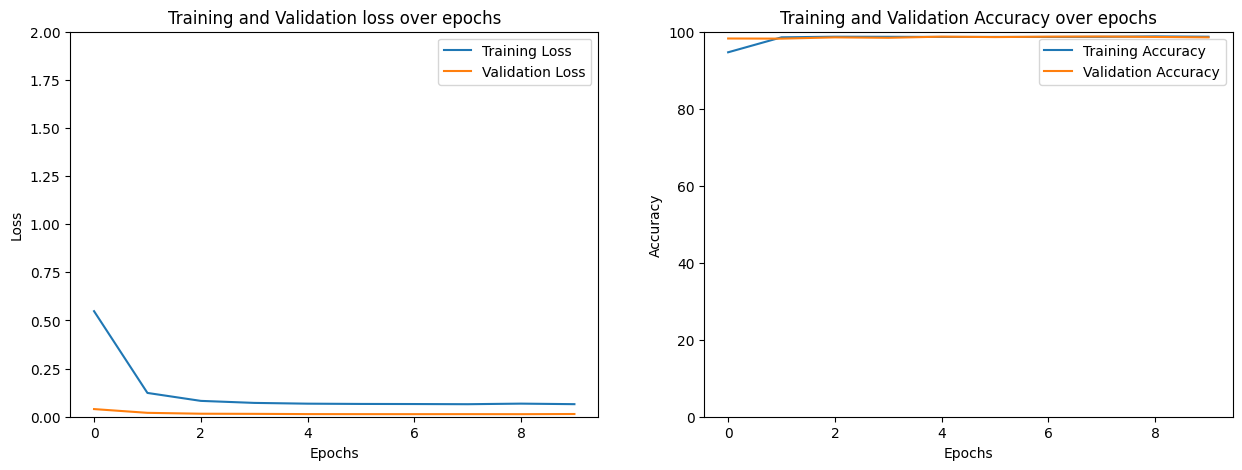

In [19]:
# VISUALIZATION

fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

axis[0].plot(total_loss_train_plot, label='Training Loss')
axis[0].plot(total_loss_valid_plot, label='Validation Loss')
axis[0].set_title('Training and Validation loss over epochs')
axis[0].set_xlabel('Epochs')
axis[0].set_ylabel('Loss')
axis[0].set_ylim([0, 2]) # 0 / 1
axis[0].legend()

axis[1].plot(total_accuracy_train_plot, label='Training Accuracy')
axis[1].plot(total_accuracy_valid_plot, label='Validation Accuracy')
axis[1].set_title('Training and Validation Accuracy over epochs')
axis[1].set_xlabel('Epochs')
axis[1].set_ylabel('Accuracy')
axis[1].set_ylim([0, 100]) # 0% - 100%
axis[1].legend()

plt.show()



In [21]:
# INFERENCE:
og_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


In [23]:
Area = 3333 / og_df['Area'].abs().max()
MajorAxisLength = 77.77 / og_df['MajorAxisLength'].abs().max()
MinorAxisLength = 55.55 / og_df['MinorAxisLength'].abs().max()
Eccentricity = 0.777777 / og_df['Eccentricity'].abs().max()
ConvexArea = 4444 / og_df['ConvexArea'].abs().max()
EquivDiameter = 69.69 / og_df['EquivDiameter'].abs().max()
Extent = 0.777777 / og_df['Extent'].abs().max()
Perimeter = 222.222 / og_df['Perimeter'].abs().max()
Roundness = 0.888888 / og_df['Roundness'].abs().max()
AspectRation = 1.444444 / og_df['AspectRation'].abs().max()

inference = model(torch.tensor([
    Area,
    MajorAxisLength,
    MinorAxisLength,
    Eccentricity,
    ConvexArea,
    EquivDiameter,
    Extent,
    Perimeter,
    Roundness,
    AspectRation
    ], dtype=torch.float32).to(device))

In [28]:
print(inference)
print(inference.item())
print(round(inference.item()))

tensor([0.1823], device='cuda:0', grad_fn=<SigmoidBackward0>)
0.18226012587547302
0
